In [1]:
import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
from ptsa.data.filters import ButterworthFilter
import sys
import os
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
from copy import copy
from scipy import stats
import pickle
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/Downloads/ptsa_plot-master/')
sys.path.append('/home1/john/johnModules')
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from general import *
from SWRmodule import *

# usually within local run
import mne
from scipy.signal import firwin,filtfilt,kaiserord
import pingouin as pg
%autoreload
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

# specific to loading UTSW data
import warnings
warnings.simplefilter('ignore')
from ptsa.data.readers import EEGReader
from ptsa.data.MatlabIO import read_single_matlab_matrix_as_numpy_structured_array
from glob import glob


/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.4, the latest is 0.4.0.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/home1/john/anaconda3/envs/env1/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.0, the latest is 0.2.1.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


## Local get ripples

In [8]:
import pandas as pd
import numpy as np
import os
import sys; sys.path.append('/home1/john/johnModules')
import dill, pickle
import mne
from copy import copy
from scipy.signal import firwin,filtfilt,kaiserord
from ptsa.data.filters import ButterworthFilter
from brain_labels import MTL_labels, LTC_labels, PFC_labels, OTHER_labels, ALL_labels # all location labels
%load_ext autoreload
%autoreload
from SWRmodule import CMLReadDFRow,get_bp_tal_struct,get_elec_regions,ptsa_to_mne
from general import superVstack
from SWRmodule import downsampleBinary,LogDFExceptionLine,getBadChannels,getStartEndArrays,getSecondRecalls,\
                    removeRepeatedRecalls,getSWRpathInfo,selectRecallType,getMTLregions,\
                    getOutputPositions,getRecallsBeforeIntrusions,getSerialposOfRecalls,getElectrodeRanges,\
                    detectRipplesHamming,detectRipplesButter
import pingouin as pg
HPC_labels,ENT_labels,PHC_labels = getMTLregions(MTL_labels)

### PARAMS ###

save_values = 1

selected_period = 'whole_retrieval' 
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on 
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

# there are three periods this code is set up to look at: periods aligned to recall, the entire retrieval period, and the encoding period
recall_type_switch = 0 # how do we select recalls?? Numbers 0:3
# 0: Original analysis taking only recalls without a recall in 2 s IRI before them
# 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur
# 2: test condition where we look at second recalls within IRI ONLY
# 3: ISOLATED only!
# 4: only first recall of every retrieval period
# 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
# 6: take only NOT first recall of every retrieval period
# 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
# 10: same as 0 but with no IRI (mostly just to see number of recalls)

selected_region = HPC_labels #HPC_labels # ENT_labels+HPC_labels

remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###

min_ripple_rate = 0.1 # Hz.
max_ripple_rate = 1.5 # Hz.
max_trial_by_trial_correlation = 0.05 # if ripples correlated more than this remove them
max_electrode_by_electrode_correlation = 1.0 #0.2 #???

filter_type = 'hamming' # see local version below for details 
# butter (Vaz algorithm)
# hamming (Norman algorithm)
# hamming125200 (Norman algorithm meant to capture "true" ripple frequency per Sullivan...Buzsaki 2011
# hamming140250 (Same idea, but higher bands)


## patient info ## (did this manually since there are so many inconsistencies in behavior/eeg labeling)


sub_selection = [5] # # [0],[1],range(11), [10]


subs = ['UT159', 'UT162', 'UT165',
        'UT167', 'UT178', 'UT185',
        'UT191', 'UT195', 'UT199',
        'UT238', 'UT255'] # UT194 is unusable
subs = np.array(subs)[sub_selection]
print(subs)

# manually assigning the actual session numbers in the behavioral folder in home/eeg/UTXXX/
session_nums = [ [1,2],[0,1],[0,1],
                 [0,1],[0,1],[0,1],
                 [0,1],[1,2],[1,2],
                 [0,1],[0,1] 
               ] # note: the missing 0s are FR sessions not in blinded condition (UT159,UT195,UT199)
session_nums = np.array(session_nums)[sub_selection]

scopo_indicator = [ [0,1],[1,0],[0,1],
                   [0,1],[1,0],[1,0],
                   [0,1],[1,0],[0,1],
                   [1,0],[0,1]
                  ] # matches session number
scopo_indicator = np.array(scopo_indicator)[sub_selection]

# the organization of the behavioral folders does not match the EEG folders so use these "experiment" names to get the EEG
# note that the folder names come from data/eeg/UTXXX/behavioral
behav_names = [ ['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],
               ['FR1','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],
               ['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine'],
               ['FR1_scopolamine','FR1_scopolamine'],['FR1_scopolamine','FR1_scopolamine']
              ]
behav_names = np.array(behav_names)[sub_selection]

# these come from the EEG filenames in data/eeg/UTXXX/eeg.noreref/UTXXX_TAKENAMEFROMHERE_DATE.001
eeg_names = [ ['FR1_scopolamine','FR1_scopolamine'],['FR1_Scopolamine','FR1'],['FR1','FR1'],
              ['FR1','FR1'],['FR1_scop','FR1_scop'],['FR1_scop','FR1_scop'],
              ['FR1_scop','FR1_scop'],['FR1_scop','FR1_scop'],['FR1_scop','FR1_scop'],
              ['FR1_scop','FR1_scop'],['FR1_scopolamine','FR1_scopolamine']
            ]
eeg_names  = np.array(eeg_names)[sub_selection]

## recall params
recall_minimum = 2000
IRI = 2000 # inter-ripple interval...remove ripples within this range (keep only first one and remove those after it)
retrieval_whole_time = 30000
# encoding params
encoding_time = 2300 # actual preentation is 1.6 s + 0.75-1.0 s so keep +700 ms so can plot +500 ms
pre_encoding_time = -700 # since minimum ISI is 0.75 s let's only plot the 500 ms before word on with a 200 ms buffer
# these aren't likely to be changed:
desired_sample_rate = 500. # in Hz. This seems like lowerst common denominator recording freq.
eeg_buffer = 300 # buffer to add to either end of IRI when processing eeg #**

soz_keep = [0,1] # 0 are good elecs and 1 are SOZ elecs. Never keep 2 (bad leads) ###
if remove_soz_ictal == 1:
    soz_keep = [0]
elif remove_soz_ictal == 2:
    soz_keep = [1]

### END PARAMS ###


if 'entorhinal' in selected_region and 'left hippocampus' in selected_region:
    region_name = 'HPC_ENT'
elif 'entorhinal' in selected_region:
    region_name = 'ENT'
elif 'left hippocampus' in selected_region:
    region_name = 'HPC'
if selected_period == 'surrounding_recall':
    psth_start = -IRI # only makes sense to look at period <= IRI
    psth_end = IRI # how long to grab data after recall
elif selected_period == 'whole_retrieval':
    psth_start = -IRI # doesn't have to be IRI just 2000 ms is convenient
    psth_end = IRI+retrieval_whole_time
elif selected_period == 'encoding':
    psth_start = pre_encoding_time
    psth_end = encoding_time
elif (selected_period == 'math') | (selected_period == 'math_retrieval'): #$$
    psth_start = -2000 # just use 2000 since math problems are actually like 5 s apart typically
    psth_end = 2000  
    
# loop across subjects and sessions    
for i_sub,sub in enumerate(subs):

    for i_session,session in enumerate(session_nums[i_sub]): # sessions numbers were manually added into a list of lists above    

        ripple_array = []; fr_array = []; 
        trial_nums = []; 
        session_ct = 0; channel_ct = 0; total_channel_ct = 0
        HPC_names = []; sub_names = []; sub_sess_names = []
        electrodes_per_session = []
        total_lists = 0; total_recalls = 0; kept_recalls = 0
        align_adjust = 0
        ent_elec_ct = []; sd_regions = []; not_sd_regions = []
        ripple_ied_accum_ct = []
        time_add_save = [];             
        encoded_word_key_array = []
        list_num_key = []

        list_recall_num_array = []; rectime_array = []; recall_before_intrusion_array = [] # new ones added 2020-11-24
        serialpos_array = [] # used to be encoding info but commandeered for surrounding_recalls ~~~
        recall_position_array = []; recall_index_array = []

        trial_by_trial_correlation = []; elec_by_elec_correlation = []
        elec_ripple_rate_array = []

        channel_coords = []; electrode_labels = []; channel_nums = []

#         try:

        ### First get the recall and word events ###

        evs = pd.DataFrame.from_records( read_single_matlab_matrix_as_numpy_structured_array(
            '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/events.mat', 'events') )   

        # UTSW data annoyingly uses 'item' instead of 'item_name'
        evs = evs.rename(columns={"item": "item_name"})

        # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
        # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
        evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)] # recalled word AND correct (from this list...False for instrusions).        
        word_evs = evs[evs['type']=='WORD'] # get words 

        if scopo_indicator[i_sub][i_session] == 1:
            print(str(len(evs_free_recall))+' recalled words for SCOPO for '+sub+'-'+str(session))
        else:
            print(str(len(evs_free_recall))+' recalled words for CONTROL for '+sub+'-'+str(session))                
        print(str(len(np.unique(word_evs.list)))+' lists')

#             # curious to grab MATH too while I'm here
#             math_evs = pd.DataFrame.from_records( read_single_matlab_matrix_as_numpy_structured_array(
#                 '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/MATH_events.mat','events') )


        # select which recalls??         
        [recall_selection_name,selected_recalls_idxs] = selectRecallType(recall_type_switch,evs_free_recall,IRI,recall_minimum)

        _,nonrepeat_indicator = removeRepeatedRecalls(evs_free_recall,word_evs) # remove free recalls that happened more than once

        # let's make sure remaining recalls are not repeated, have eeg, and are not from non-practice lists
        good_recalls = selected_recalls_idxs & np.array(evs_free_recall.eegoffset>-1) & np.array(evs_free_recall.list > -1) & (nonrepeat_indicator>0)
        evs_free_recall = evs_free_recall[good_recalls]

        # get temp key of recalls that lead to intrusions ~~~
        pre_intrusion_recalls = getRecallsBeforeIntrusions(evs,evs_free_recall)
        
        if selected_period == 'surrounding_recall':
            if len(evs_free_recall)<=1: #...and that any recalls are left!
                continue

        # get output position in each list for this session's recalls
        session_corrected_list_ops = getOutputPositions(evs,evs_free_recall)


        ### Get UTSW localizations ###

        contacts = pd.DataFrame.from_records(np.recfromtxt('/data/eeg/'+sub+'/eeg.noreref/jacksheet.txt', encoding='utf-8'))
        contacts = contacts.rename(columns={'f0':'contact', 'f1':'label'})        

        with open('/data/eeg/'+sub+'/docs/'+sub+'_depth_el_info.txt', 'r') as f:
            lines = f.readlines()
        lines = [line.rstrip('\n') for line in lines]

        depth_info = pd.DataFrame(columns=['label', 'description'])
        for line in lines:
            split = line.split()
            try:
                depth_info = depth_info.append({'label':split[1], 'description':' '.join(split[2:])}, ignore_index=True)
            except IndexError:
                continue
        contacts = depth_info.merge(contacts, how='inner') # note it's contacts and not pairs


        ###  Load eeg ###

        if selected_period == 'surrounding_recall':
            total_recalls = total_recalls + len(evs_free_recall) # get total recalls from lists
            total_lists = total_lists + len(evs[evs.type=='WORD'].list.unique()) # get total lists
            kept_recalls = kept_recalls + len(evs_free_recall)
            eeg_events = evs_free_recall

#             # fix EEG offset due to Unity implementation error
#             eeg_events = correctEEGoffset(sub,session,exp,reader,eeg_events) # I dn't think UTSW has this error

        elif selected_period == 'whole_retrieval':
            # grab whole retrieval periods for a better baseline of SWRs
            evs_rets = evs[evs.type=='REC_START']
            evs_rets = evs_rets[evs_rets.list > -1] # remove practice lists **  

            # remove trials that aren't working
            if (sub == 'UT178') or ((sub == 'UT238') and (session == 1)):
                evs_rets = evs_rets[evs_rets.eegoffset > 0] # 5 RET_STARTs at end of one session has eegoffset=0, so can't use -1
            else:
                evs_rets = evs_rets[evs_rets.eegoffset > -1] # any trial with no eeg gets removed by cmlreaders so it's not in ripple_array 
            if (sub == 'UT195') and (session==1):
                evs_rets = evs_rets[:-1] # this trial doesn't load

            eeg_events = evs_rets


        # We want to get the base file name in a clean/systematic way, probably by globbing on the experiment_session name 
        # (except that experiment names were inconsistent so I manually wrote them out above)
        root = '/data/eeg'
        paths = glob(os.path.join(root, sub, 'eeg.noreref', sub+'_'+eeg_names[i_sub][i_session]+'_'+str(session)+'*'), recursive=True)
        file_base = os.path.basename(paths[0]).split('.')[0]
        base_name = os.path.join(os.path.dirname(paths[0]), file_base)

        eeg_events['eegfile'] = base_name

        eeg_ptsa = EEGReader(eeg_events.to_records(),
                        channels= contacts.contact.values[contacts.description.str.contains('hippocampus')],
                        start_time=(psth_start-eeg_buffer+align_adjust)/1000,
                        end_time=(psth_end+eeg_buffer+align_adjust)/1000).read()
        # switch to event X channel X time (to match reader.load_eeg)
        eeg_ptsa = eeg_ptsa.transpose('events','channels','time')
        eeg_ptsa = eeg_ptsa.rename({'events':'event','channels':'channel'}) # to get same naming conventions from reader.load_eeg

        sr = eeg_ptsa.samplerate        
        sr = int(sr.values)

        # If using Vaz algo can't do >250 Hz IED detection so don't use this sub
        if (sr<990) and filter_type=='butter': #^^^
            print('Cannot use '+sub+' since using Vaz algo and sr ≤ 500!')
            continue        

        # if weird samplerate, add a few ms to make the load work
        if (499<sr<500) | (998<sr<1000):
            time_add = 1
            if (499<sr<500):
                sr = 500
            elif (998<sr<1000):
                sr = 1000
            while eeg.shape[2] < (psth_end-psth_start+2*eeg_buffer)/(1000/sr):
                eeg = reader.load_eeg(events=eeg_events, rel_start=psth_start-eeg_buffer+align_adjust, 
                                      rel_stop=psth_end+eeg_buffer+time_add+align_adjust, clean=True, scheme=pairs)
                if time_add>50: #**
                    continue
                time_add+=1
            time_add_save.append(time_add)
            eeg.samplerate = sr # need to overwrite those that were just fixed

#             eeg_ptsa = eeg.to_ptsa() # already ptsa when using EEGReader
#             eeg = None # clear variable
#     #         break;break;break # to look at eeg_ptsa (plots at bottom of notebook) before filtering

        # line removal...don't do 120 for now
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[58.,62.], filt_type='stop', order=4).filter()
        eeg_ptsa = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[178.,182.], filt_type='stop', order=4).filter()

        ## FILTERS ##
        trans_width = 5. # Width of transition region, normalized so that 1 corresponds to pi radians/sample. 
        # That is, the frequency is expressed as a fraction of the Nyquist frequency.
        ntaps = (2/3)*np.log10(1/(10*(1e-3*1e-4)))*(sr/trans_width) # gives 400 with sr=500, trans=5
        # formula from Belanger's Digital Processing of Signals
        # see https://dsp.stackexchange.com/questions/31066/how-many-taps-does-an-fir-filter-need for how to use

        if sr == 512 or sr == 1024 or sr == 1023.999: # last one fixes R1221P @@
            ntaps = np.ceil(ntaps)
        FIR_bandstop = firwin(int(ntaps+1), [70.,178.], fs=sr, window='hamming',pass_zero='bandstop')
    #     FIR_bandpass = firwin(int(ntaps), [70.,180.], fs=sr, window='hamming',pass_zero='bandpass')
        bandstop_25_60 = firwin(int(ntaps+1), [20.,58.], fs=sr, window='hamming',pass_zero='bandstop') # Norman 2019 IED
    #     bandstop_60_80 = firwin(int(ntaps+1), [60.,80.], fs=sr, window='hamming',pass_zero='bandstop') # Gelinas 2016 IED
        nyquist = sr/2
        ntaps40, beta40 = kaiserord(40, trans_width/nyquist)
        kaiser_40lp_filter = firwin(ntaps40, cutoff=40, window=('kaiser', beta40), scale=False, nyq=nyquist, pass_zero='lowpass')

        # filter for ripples using filter selected above

        if filter_type == 'hamming':
            # need to subtract out to get the filtered signal since default is bandstop but want to keep it as PTSA        
            eeg_rip_band = eeg_ptsa-filtfilt(FIR_bandstop,1.,eeg_ptsa) 
            #         eeg_rip_band = filtfilt(FIR_bandpass,1.,eeg_ptsa) # can't use ptsa_to_mne this way so use eeg - bandstopped signal
            eeg_ied_band = eeg_ptsa-filtfilt(bandstop_25_60,1.,eeg_ptsa)
        elif filter_type == 'butter':
            eeg_rip_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[80.,120.], filt_type='bandpass',order=2).filter()
#             if sr == 500: # dropped below 250 Hz because too close Nyquist
#                 eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=250., filt_type='highpass',order=2).filter() 
#             elif sr >= 1000:    
#                 #this seems okay since large range far from Nyquist...problem is it likely misses key events
            eeg_ied_band = ButterworthFilter(timeseries=eeg_ptsa, freq_range=[250.,490.], filt_type='bandpass',order=2).filter() #^^^
            eeg_raw = ptsa_to_mne(eeg_ptsa,[0,psth_end-psth_start+2*eeg_buffer])    #**  
#         eeg_ptsa = None # clear variable # no reason to do this in local version...really for cluster

        eeg_rip_band = ptsa_to_mne(eeg_rip_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_rip_band.apply_hilbert(envelope=True)
        eeg_ied_band = ptsa_to_mne(eeg_ied_band,[0,psth_end-psth_start+2*eeg_buffer]) #** 
        _ = eeg_ied_band.apply_hilbert(envelope=True)


        # I don't know if UTSW has bad_leads

#             # get bad channel mask
#             try:
#                 elec_cats = reader.load('electrode_categories') # this is cool
#             except:
#                 if remove_soz_ictal == 1: # if no electrode_categories file then don't consisder this patient
#                     e = 'No electrode categories for '+sub+', session '+str(session)
#                     LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                     continue
#                 else:
#                     elec_cats = []

#             bad_bp_mask = getBadChannels(tal_struct,elec_cats,remove_soz_ictal)

#             # this was specific to FR1/catFR1 sessions I went through manually
#             electrode_search_range = getElectrodeRanges(elec_regions,exp,sub,session,mont)


        region_electrode_ct = 0
        total_electrode_ct = 0
        session_ripple_rate_by_elec = []
#             for channel in electrode_search_range:
        for channel in range(np.shape(eeg_ptsa)[1]): # every channel in hippocampus due to how contacts is selected above

#                 if (elec_regions[channel] in selected_region) & \
#                 (bad_bp_mask[channel] in soz_keep): # selecting for SOZ or not ###

            total_channel_ct+=1 # total channels before artifact removal

            # get data from MNE container 
            eeg_rip = eeg_rip_band.get_data()[:,channel,:]     
            eeg_ied = eeg_ied_band.get_data()[:,channel,:]

            # select detection algorithm (note that iedlogic is same for both so always run that)
            if filter_type == 'hamming':
                # filter IEDs 
                eeg_ied = eeg_ied**2 # already rectified now square
                eeg_ied = filtfilt(kaiser_40lp_filter,1.,eeg_ied) # low pass filter  
                mean1 = np.mean(eeg_ied)
                std1 = np.std(eeg_ied)
                iedlogic = eeg_ied>=mean1+4*std1 # Norman et al 2018            
                # detect ripples
                ripplelogic = detectRipplesHamming(eeg_rip,trans_width,sr,iedlogic)
            elif filter_type == 'butter':
                eeg_mne = eeg_raw.get_data()[:,channel,:]
                # detect ripples
                ripplelogic, iedlogic = detectRipplesButter(eeg_rip,eeg_ied,eeg_mne,sr)             

#                 ripple_ied_accum_ct.append([sub,session,sr,sum(ripplelogic),sum(iedlogic),sum(ripplelogic2),sum(iedlogic2),
#                                             sum(ripplelogic_enc),sum(iedlogic_enc)])

            if filter_type == 'butter': # ^^^
                desired_sample_rate = 1000 # for Vaz algo
            if sr>desired_sample_rate: # downsampling here for anything greater than 500 (hamming) or 1000 (butter)
                ripplelogic = downsampleBinary(ripplelogic,sr/desired_sample_rate)

            # ripples are detected, so can remove buffers now #**
            ripplelogic = ripplelogic[:,int(eeg_buffer/(1000/desired_sample_rate)):
                                      int((psth_end-psth_start+eeg_buffer)/(1000/desired_sample_rate))]
            
            # skip this electrode if the ripple rate is below threshold
            temp_start_array,_ = getStartEndArrays(ripplelogic)
            elec_ripple_rate = sum(temp_start_array)/temp_start_array.shape[0]/((psth_end-psth_start)/1000)
            if elec_ripple_rate < min_ripple_rate:
                print(sub+', '+str(session)+' skipped b/c below ripple rate thresh for ch.: '+str(channel))
                continue
            elif elec_ripple_rate > max_ripple_rate:
                print(sub+', '+str(session)+' skipped b/c ABOVE ripple rate thresh for ch.: '+str(channel))
                continue # skip this electrode

            # check the ripples for this electrode and make sure they're not super correlated across trials

            # first, bin the array so can get more realistic correlation not dependent on ms timing
            binned_ripplelogic = downsampleBinary(ripplelogic,10) # downsample by 10x so 10 ms bins
            trial_ripple_df = pd.DataFrame(data=np.transpose(binned_ripplelogic))
            num_cols = len(list(trial_ripple_df))
            trial_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
            temp_tbt_corr = np.mean(pg.pairwise_corr(trial_ripple_df,method='spearman').r)
            if temp_tbt_corr > max_trial_by_trial_correlation:
                print(sub+', '+str(session)+' skipped b/c above trial-by-trial correlation for ch.: '+str(channel))
                continue

            ## if this electrode passes SAVE data ##

            trial_by_trial_correlation.append(temp_tbt_corr) # corr b/w trials
            elec_ripple_rate_array.append(elec_ripple_rate) # record the average ripple rate for this electrode

            # append arrays across electrodes
            ripple_array = superVstack(ripple_array,ripplelogic) # append across electrodes
            session_ripple_rate_by_elec = superVstack(session_ripple_rate_by_elec,np.mean(binned_ripplelogic,0)) # for correlation b/w elecs below

            if selected_period == 'encoding':
                encoded_word_key_array.append(encoded_word_key) # save the key for each electrode so easier to unpack later
                serialpos_array.append(evs_encoding_words.serialpos)
                if len(encoded_word_key) != ripplelogic.shape[0]:
                    e = 'Encoded word key and ripple_array dont match for '+sub+str(session)+'_'+str(channel)
                    LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')

            elif selected_period == 'whole_retrieval':
                # make a matrix of the times of free recall if looking at whole retrieval period
                list_nums = eeg_events.list.unique() # count all list numbers for this session
                temp_fr_array = np.zeros((len(list_nums),retrieval_whole_time))
                for ln in list_nums:
                    list_times = evs_free_recall[evs_free_recall.list==ln].rectime # I confirmed these are accurate relative to REC_START
                    temp_fr_array[ln-list_nums[0]][np.array(list_times)] = 1 # subtract from list_nums[0] to recenter fr_array on 0 trial           
                fr_array = superVstack(fr_array,temp_fr_array)

            elif selected_period == 'surrounding_recall':    # ~~~                                
                # adding new values 2020-11-24 for some suggested analyses from group

                # key of serialpos for recalls
                list_nums = evs_free_recall.list.unique()   
                temp_recalls_serialpos = []
                for ln in list_nums:
                    temp_sp = getSerialposOfRecalls(evs_free_recall,word_evs,ln)
                    temp_recalls_serialpos.extend(temp_sp)
                    # recall number per list
                    list_recall_num_array.extend(np.tile(len(temp_sp),len(temp_sp)))
                    # recall position per list
                    recall_position_array.extend(np.arange(len(temp_sp))+1) # 1-indexed
                serialpos_array.extend(np.array(temp_recalls_serialpos))

                # key of rectimes for recalls
                rectime_array.extend(np.array(evs_free_recall.rectime)) 

                # key of recall index numbers so I can use SWR times from start_array to grab SWR-locked EEG
                recall_index_array.extend(np.array(evs_free_recall.index))

                # key of recalls before intrusions
                recall_before_intrusion_array.extend(pre_intrusion_recalls)

            elif (selected_period == 'math') | (selected_period == 'math_retrieval'):

                list_nums = eeg_events.list.unique()  
                for ln in list_nums:
                    num_corr_math = sum(eeg_events.list==ln)
                    list_recall_num_array.extend(np.tile(num_corr_math,num_corr_math))
                    recall_position_array.extend(np.arange(num_corr_math+1)) # correct math position

                # either way save the rectime array
                rectime_array.extend(np.array(eeg_events.rectime)) 
                encoded_word_key_array.extend(np.array(eeg_events.test)) # record the actual math problem  

            channel_ct+=1 # total channels from beginning 
            region_electrode_ct+=1 # channel ct for this session
#                 HPC_names.append(elec_regions[channel])
            sub_names.append(sub)
            sub_sess_names.append(sub+'-'+str(session))
            print('Cumulative array size after channel: '+str(channel))
            print(ripple_array.shape)
            trial_nums = np.append(trial_nums,ripplelogic.shape[0])
            electrode_labels.append(contacts.iloc[channel].label) # get names of electrodes so can look for them across sessions
            channel_nums.append(channel)
            list_num_key.extend(eeg_events.list)

            # get atlas coordinates for this electrode
            if 'avg.x' in contacts:
                temp_coord = np.append(pairs.iloc[channel]['avg.x'],np.append(pairs.iloc[channel]['avg.y'],pairs.iloc[channel]['avg.z']))
            elif 'ind.x' in contacts:
                temp_coord = np.append(pairs.iloc[channel]['ind.x'],np.append(pairs.iloc[channel]['ind.y'],pairs.iloc[channel]['ind.z']))
            else:
                temp_coord = np.empty(3); temp_coord[:] = np.nan
            channel_coords.append(temp_coord)

            # additional check to make sure eeg was recorded for all events
            if selected_period == 'surrounding_recall':
                if evs_free_recall.shape[0] != ripplelogic.shape[0]:
                    # this happens because eeg wasn't turned on. remove eegoffset=-1 trials; I DO THIS ABOVE NOW
                    good_evs_free_recall = evs_free_recall.eegoffset > -1
                    session_corrected_list_ops = session_corrected_list_ops[good_evs_free_recall]
                    e = sub+str(session)+'_still unrecorded eegs'
                    LogDFExceptionLine(row, e, 'SWR_get_eeg_log.txt')
#                 ordinal_position_array.extend(session_corrected_list_ops) # update for each electrode

        # before we keep all the electrodes in this session, remove sessions with elecs that are highly correlated.
        # this really only makes sense for the cluster version, since I only do a session at a time here
        if np.sum(session_ripple_rate_by_elec)>0 and region_electrode_ct>1:
            session_ripple_df = pd.DataFrame(data=np.transpose(session_ripple_rate_by_elec))
            num_cols = len(list(session_ripple_df))
            session_ripple_df.columns = ['col_' + str(i) for i in range(num_cols)] # generate range of ints for suffixes
#             print(pg.pairwise_corr(session_ripple_df,method='spearman').r) # print the elec-by-elec correlations
            elec_by_elec_correlation = np.mean(pg.pairwise_corr(session_ripple_df,method='spearman').r) # correlation b/w elecs
            if elec_by_elec_correlation > max_electrode_by_electrode_correlation:
                print('Correlation b/w electrodes too high, corr = '+str(elec_by_elec_correlation))
            else:
                print('good set of electrodes (not correlated with each other)')

        electrodes_per_session = np.append(electrodes_per_session,region_electrode_ct)
        session_ct+=1


#         except Exception as e:
#             LogDFExceptionLine(row, e, 'LocalSWR_get_eeg_log.txt') #np.save('SWRscript_FR1.npy', ['Exception', str(e.__class__), str(e)])
#             continue
                
             
        ### save separately for each subject + session ###    
                
        if save_values == 1:

            # get strings for path name for save and loading cluster data
            soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)

            path_name = '/scratch/john/SWR_scopolamine/'+subfolder
            if os.path.isdir(path_name) == False:
                os.mkdir(path_name)
            # hard code experiment as 'FR1_scopolamine' since there are too many changes in nomenclature...will just use manual indexing for scopo sessions
            fn = os.path.join(path_name, 
                'SWR_FR1_scopolamine'+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                              '_'+soz_label+'_'+filter_type+'.p')     # +'_no_param_removal.p')   #+'.p')  #+'.intrusions.p') #'.-wrong.p')
            with open(fn,'wb') as f:
                pickle.dump({'region_electrode_ct':region_electrode_ct,'total_electrode_ct':total_electrode_ct, 
                            'HPC_names':HPC_names, 'sub_sess_names':sub_sess_names,
                            'ripple_array':ripple_array, 'time_add_save':time_add_save,
                            'trial_nums':trial_nums,'list_num_key':list_num_key,
                            'encoded_word_key_array':encoded_word_key_array,
                            'serialpos_array':serialpos_array,'list_recall_num_array':list_recall_num_array, # ~~
                            'rectime_array':rectime_array,'recall_before_intrusion_array':recall_before_intrusion_array,
                            'recall_position_array':recall_position_array,'recall_index_array':recall_index_array, # ~~
                            'fr_array':fr_array, 'sub_names':sub_names,
                            'total_recalls':total_recalls, 'kept_recalls':kept_recalls,
                            'trial_by_trial_correlation':trial_by_trial_correlation, # one value for each electrode for this session
                            'elec_by_elec_correlation':elec_by_elec_correlation,
                            'elec_ripple_rate_array':elec_ripple_rate_array,
                            'electrode_labels':electrode_labels,'channel_coords':channel_coords,'channel_nums':channel_nums}, f)
                

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
['UT185']
0 recalled words for SCOPO for UT185-0
25 lists
Cumulative array size after channel: 0
(25, 17000)
Cumulative array size after channel: 1
(50, 17000)
Cumulative array size after channel: 2
(75, 17000)
good set of electrodes (not correlated with each other)
148 recalled words for CONTROL for UT185-1
25 lists
Cumulative array size after channel: 0
(25, 17000)
Cumulative array size after channel: 1
(50, 17000)
Cumulative array size after channel: 2
(75, 17000)
good set of electrodes (not correlated with each other)


In [128]:
fn

'/scratch/john/SWR_scopolamine/WHOLE_RETRIEVAL/SWR_FR1_scopolamine_UT162_1_HPC_whole_retrieval_soz_in_hamming.p'

## Load data from local get ripples

In [124]:
## go through and append across sessions


## patient info ## (did this manually since there are so many inconsistencies in behavior/eeg labeling)

scopo_selection = 1
# 0 for control only
# 1 for scopo_only
# 2 for all sessions

sub_selection = range(11) #[0,2,3,6,7,10] #range(10) # [0],[1],range(10)
# [0,2,3,6,7,10] patients that actually recall more than 0-3% compared to control

subs = ['UT159', 'UT162', 'UT165',
        'UT167','UT178', 'UT185',
        'UT191', 'UT195','UT199',
        'UT238', 'UT255'] # UT194 is unusable
subs = np.array(subs)[sub_selection]
# 'UT255' is new but I don't see it?

# manually assigning the actual session numbers in the behavioral folder in home/eeg/UTXXX/
session_nums = [ [1,2],[0,1],[0,1],
                 [0,1],[0,1],[0,1],
                 [0,1],[1,2],[1,2],
                 [0,1],[0,1] 
               ] # note: the missing 0s are FR sessions not in blinded condition (UT159,UT195,UT199)
session_nums = np.array(session_nums)[sub_selection]

scopo_indicator = [ [0,1],[1,0],[0,1],
                   [0,1],[1,0],[1,0],
                   [0,1],[1,0],[0,1],
                   [1,0],[0,1]
                  ] # matches session number
scopo_indicator = np.array(scopo_indicator)[sub_selection]


## PARAMS

selected_period = 'whole_retrieval'
# 'surrounding_recall': aligned to time of free recall 
# 'whole_retrieval': aligned to beginning of retrieval period (beep_off)
# 'encoding': aligned to word_on 
# 'math': aligned to math problem on
# 'math_retrieval': aligned to math problem key-in time

recall_type_switch = 0
    # (1 and 3 are basically opposites...those with a subsequent recall and those without)
    # 0: Original analysis taking only recalls without a recall in 2 s IRI before them
    # 1: Take these same recalls, but keep only those WITH a recall within 2 s after they occur 
    # 2: test condition where we look at second recalls within IRI ONLY (there is an initial recall in 2 s before current recall)
    # 3: isolatead recalls with no other recalls +/- RECALL_MINIMUM s
    # 4: only first recall of every retrieval period
    # 5: take only those recalls that come second in retrieval period within 2 s of first retrieval
    # 6: take only NOT first recall of every retrieval period (opposite of 4)
    # 7: take only NOT first recall AND ISOLATED trials (this should REALLY maximize SWR bump)
    # 8: take only 2nd recalls
    # 10: same as 0 but with no IRI (mostly just to see number of recalls)
recall_minimum = 2000 # used if recall_type_switch = 3
region_name = 'HPC' #'ENT' #'HPC' #HPC_ENT #ENT #HPC # PHC 
remove_soz_ictal = 0 # 0 for nothing, 1 for remove SOZ, 2 for keep ONLY SOZ ###
filter_type = 'hamming' # butter/hamming/hamming125200/tried hamming140250 for math

###

# get strings for path name for save and loading cluster data
if recall_type_switch in [0,4,6,8]:
    # for these I'm using all trials, but selecting for which recall after the fact
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,0,selected_period,recall_minimum)
else: # these others I haven't set up indexing (see >line 100 in this cell)
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
    
ripple_array = []; 
trial_nums = []; encoded_word_key_array = []
HPC_names = []; sub_sess_names = []
region_electrode_ct = []; sub_names = []
trial_by_trial_correlation = []; elec_ripple_rate_array = []
elec_by_elec_correlation = []; fr_array = []
list_num_key = []

serialpos_array = []; list_recall_num_array = []; # ~~~
rectime_array = []; recall_before_intrusion_array = []
recall_position_array = []

electrode_labels = []; channel_coords = []; channel_nums = []

# loop across subjects and sessions    
for i_sub,sub in enumerate(subs):

    for i_session,session in enumerate(session_nums[i_sub]): # sessions numbers were manually added into a list of lists above 
        
        scopo_session_indicator = scopo_indicator[i_sub][i_session]
        
        if (scopo_selection == scopo_session_indicator) | (scopo_selection == 2):

#             try:
                path_name = '/scratch/john/SWR_scopolamine/'+subfolder
                fn = os.path.join(path_name,
                    'SWR_FR1_scopolamine'+'_'+sub+'_'+str(session)+'_'+region_name+'_'+selected_period+recall_selection_name+
                                  '_'+soz_label+'_'+filter_type+'.p') #'_no_param_removal.p')   #'.p') #+'.intrusions.p') # +'.-wrong.p') (for wrong math)
                with open(fn,'rb') as f:
                    dat = pickle.load(f)

                    ripple_array = superVstack(ripple_array,dat['ripple_array']) 
                    region_electrode_ct.append(dat['region_electrode_ct'])
                    encoded_word_key_array.extend(dat['encoded_word_key_array'])
                    HPC_names.extend(dat['HPC_names'])
                    sub_sess_names.extend(dat['sub_sess_names'])
                    sub_names.extend(dat['sub_names'])
                    trial_nums = np.append(trial_nums,dat['trial_nums'])

                    # load info
                    print(sub+'-'+str(session))
                    np.shape(ripple_array)
                    sum(trial_nums)

                    trial_by_trial_correlation.extend(dat['trial_by_trial_correlation']) # one value for each electrode for this session
                    elec_by_elec_correlation = np.append(elec_by_elec_correlation,dat['elec_by_elec_correlation'])
                    elec_ripple_rate_array.extend(dat['elec_ripple_rate_array']) # ripple rate by electrode so append
                    #,'total_recalls':total_recalls, 'kept_recalls':kept_recalls}, f)
                    if selected_period == 'whole_retrieval':
                        if np.shape(dat['fr_array'])[0]!=np.shape(dat['ripple_array'])[0]:
                            print(sub+str(session))
                        serialpos_array.extend(dat['serialpos_array'])
                        fr_array = superVstack(fr_array,dat['fr_array'])
                    if selected_period == 'encoding':
                        serialpos_array.extend(dat['serialpos_array'])
                    if selected_period == 'surrounding_recall': # ~~~
                        serialpos_array.extend(dat['serialpos_array']); list_recall_num_array.extend(dat['list_recall_num_array']); # ~~
                        rectime_array.extend(dat['rectime_array']); recall_before_intrusion_array.extend(dat['recall_before_intrusion_array'])
                        recall_position_array.extend(dat['recall_position_array'])
                    if (selected_period == 'math') | (selected_period == 'math_retrieval'):
                        rectime_array.extend(dat['rectime_array'])
                        recall_position_array.extend(dat['recall_position_array']); list_recall_num_array.extend(dat['list_recall_num_array'])

                    electrode_labels.extend(dat['electrode_labels'])
                    channel_coords.extend(dat['channel_coords'])
                    channel_nums.extend(dat['channel_nums'])
                    list_num_key.extend(dat['list_num_key'])

#             except Exception as e:
# #                 LogDFExceptionLine(row, e, 'LocalSWR_load_eeg_log.txt')  
#                 error=1

print('**Done reading data**')
        
## loading *all* the recalls with 0, but if it's 4 or 6 load just those trials

# trying new method of loading...translate these to ripple_array length dependent on recall_type_switch 
# (this way I can always load from recall_type_switch = 0)

subject_name_array,session_name_array,electrode_array,channel_coords_array,channel_nums_array = getSubSessPredictorsWithChannelNums(
        sub_names,sub_sess_names,trial_nums,electrode_labels,channel_coords,channel_nums)

if selected_period == 'surrounding_recall':
    if recall_type_switch == 4:
        temp_recall_idxs = np.array(recall_position_array)==1
    elif recall_type_switch == 6:
        temp_recall_idxs = np.array(recall_position_array)>1
    elif recall_type_switch == 8:
        temp_recall_idxs = np.array(recall_position_array)==2
    else:
        temp_recall_idxs = np.array(recall_position_array)>=0
    serialpos_array = np.array(serialpos_array)[temp_recall_idxs]
    recall_before_intrusion_array = np.array(recall_before_intrusion_array)[temp_recall_idxs]
    list_num_key = np.array(list_num_key)[temp_recall_idxs]
    rectime_array = np.array(rectime_array)[temp_recall_idxs]
    list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
    recall_position_array = np.array(recall_position_array)[temp_recall_idxs]
elif (selected_period == 'math') | (selected_period == 'math_retrieval'):
    temp_recall_idxs = np.array(recall_position_array)>=0 # just keep them all for math
    encoded_word_key_array.extend(dat['encoded_word_key_array'])
    rectime_array = np.array(rectime_array)[temp_recall_idxs]
    list_recall_num_array = np.array(list_recall_num_array)[temp_recall_idxs]
    recall_position_array = np.array(recall_position_array)[temp_recall_idxs]    
elif selected_period == 'whole_retrieval':
    temp_recall_idxs = np.array(list_num_key)>=0
subject_name_array = np.array(subject_name_array)[temp_recall_idxs]
session_name_array = np.array(session_name_array)[temp_recall_idxs]
electrode_array = np.array(electrode_array)[temp_recall_idxs]
channel_coords_array = np.array(channel_coords_array)[temp_recall_idxs]
channel_nums_array = np.array(channel_nums_array)[temp_recall_idxs]
ripple_array = np.array(ripple_array)[temp_recall_idxs]

    
print('**Done translating to ripple_array frame**!!')
    
## some info on data loaded from cluster runs ##
ripple_array.shape

region_electrode_ct = np.array(region_electrode_ct)
# print('Number of electrodes in each session: '); region_electrode_ct
print('From '+str(sum(region_electrode_ct>0))+'/'+str(len(region_electrode_ct))+' sessions with >0 '+region_name+' electrodes')
print('Total electrodes: '+str(sum(region_electrode_ct)))
print('Length of HPC names: '+str(len(HPC_names)))
print('Total trials: '+str(np.sum(trial_nums)))
print('Unique sessions: '+str(len(np.unique(sub_sess_names))))
print('Unique subjects: '+str(len(np.unique(sub_names))))

# some info about regions 
print('Total electrodes: '+str(len(HPC_names)))
unique_names = np.unique(HPC_names); print(unique_names)
for name in unique_names:
    num_elecs = sum(np.array([names.find(name) for names in HPC_names])>=0)
    print(str(num_elecs)+' for '+name)
# channel_nums

UT159-2


(200, 17000)

200.0

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/john/SWR_scopolamine/WHOLE_RETRIEVAL/SWR_FR1_scopolamine_UT162_0_HPC_whole_retrieval_soz_in_hamming.p'

## get start array

In [121]:
## DO YOU WANT TO SELECT A SUBFIELD or OUTPUT POSITION?? ##  

### UTSW doesn't do subfield localization for SCOPO data so all we can say is "hippocampus"

select_subfield = False   # note: if you already ran this once, have to load again from data
                          # also this is only for HPC. So set to FALSE for ENT and PHC
    
# # select for subfield if HPC
# if select_subfield == True:
#     location_selected = 'dg' #'dg' # 'ca3' # 'dg' 'ca1' # sub # ['ca1','dg']
#         # left # right # left hippocampus # right hippocampus # hippocampus
#         # to see number of each: sum(np.array([names.find('sub') for names in HPC_names])>=0)
# else:
#     location_selected = ''
    

### Use a task condition to select recalls?? ###
### ...will select first one that's not 0    ###
select_ordinal_position = 0              # select only recalls at given output position. 0 means it's off ##DEPRECATED
select_list_position = 0 #[1,2,3] #[12]  # select only recalls at given position from encoding list. 
                                         # 0 means it's off. Must be list
select_less_than_rectime = 0             # select only recalls < this number % 5000
select_greater_than_rectime = 0          # select only recalls ≥ this number % 5000
select_lists_with_recalls = 0 # list(np.arange(3,13)) # [1] so this would select ≥4 recalls. Must be list hence the list(arange...)
                                         # select only recalls that come from lists with number in this list
select_intrusions_next = 0               # select recalls that lead to intrusions
    
if filter_type.find('hamming') != -1:
    desired_sample_rate = 500.
else:
    desired_sample_rate = 1000.
sr = desired_sample_rate # fixed at this value since this is the minimum across data and can always downsample
sr_factor = 1000/desired_sample_rate

print('Total electrodes loaded: '+str(len(trial_nums)))
print('from '+str(len(np.unique(sub_sess_names)))+' sessions from '+str(len(np.unique(sub_names)))+' subjects with trial nums:')
print(trial_nums[0:20])
print('Trial sum = '+str(np.sum(trial_nums)))
print(HPC_names[0:20])
print('Number of sub_sess names: '+str(len(sub_sess_names)))


start_array,end_array = getStartEndArrays(ripple_array) # get start array
 
# # if selected an output position
# if select_ordinal_position > 0:
#     if np.min(ordinal_position_array) == 0: # only update this once (so don't have to reload data from files)
#         ordinal_position_array = np.array(ordinal_position_array)+1 # now 1-indexed
#     selected_recalls = ordinal_position_array==select_ordinal_position
# elif type(select_list_position) == list:
#     selected_recalls = [sp in select_list_position for sp in serialpos_array]
# elif select_intrusions_next == 1:
#     selected_recalls = np.array(recall_before_intrusion_array)==True
# elif select_less_than_rectime > 0:
#     selected_recalls = np.array(rectime_array)<select_less_than_rectime
# elif select_greater_than_rectime > 0:
#     selected_recalls = np.array(rectime_array)>=select_greater_than_rectime
# elif type(select_lists_with_recalls) == list:
#     selected_recalls = [recall in select_lists_with_recalls for recall in list_recall_num_array]
# else:
#     selected_recalls = np.ones(len(start_array),dtype=bool)
    
# # get locations if selected

# if select_subfield == True:
#     # create the full vector of location name predictors
#     location_names = []
#     for s in range(len(HPC_names)):
#         new_trials = int(trial_nums[s])
#         location_names.extend(np.tile(HPC_names[s],new_trials))  
        
#     # now can get mask of trials in this location
    
#     #first, if there are two locations to combine, sort that out (DG and CA1 in particular)
#     location_mask = np.zeros(len(location_names))
#     for s in range(len(location_names)):
#         if type(location_selected)==list:
#             if location_names[s].find(location_selected[0])>=0 or location_names[s].find(location_selected[1])>=0:
#                 location_mask[s] = True
#         elif type(location_selected)==str:
#             if location_names[s].find(location_selected)>=0:
#                 location_mask[s] = True
# else:
#     location_mask = np.ones(len(start_array))

# # gotta translate this to new frame as well from idxs in load step if selected subfield
# if select_subfield == True: 
#     location_mask = location_mask[temp_recall_idxs] 

# # combine location and sorted recalls to get new ripple array:
# updated_recalls = (location_mask+selected_recalls)==2
    
# # translate these predictors to vector and select recalls
# start_array = start_array[updated_recalls]
# end_array = end_array[updated_recalls] # used for duration calculations
# subject_name_array = np.array(subject_name_array)[updated_recalls]
# session_name_array = np.array(session_name_array)[updated_recalls]
# electrode_array = np.array(electrode_array)[updated_recalls]
# channel_coords_array = np.array(channel_coords_array)[updated_recalls]
# channel_nums_array = np.array(channel_nums_array)[updated_recalls]
# if selected_period in ['surrounding_recall','math','math_retrieval']:
#     list_recall_num_array = list_recall_num_array[updated_recalls] # for subject-level analysis
#     rectime_array = np.array(rectime_array)[updated_recalls]
    
print('Got start_array with '+str(start_array.shape[0])+' trials!')

sub_elec = [subject_name_array[i]+electrode_array[i] for i in range(len(electrode_array))]
print('Number of electrodes: '+str(len(np.unique(sub_elec))))
print('...from '+str(len(np.unique(subject_name_array)))+' patients')
        
# # plot whole retrieval period with FR events superimposed on SWRs
# if selected_period == 'whole_bretrieval':
#     start_array2 = start_array # for whole retrieval period
#     print('Base SWRs/30 s retrieval: '+str(sum(start_array2)/start_array2.shape[0]/(30000/1000)))
#     ## can go straight to "SWRs by time in retrieval period" from here
# else:
#     print('SWRs rate in 4 s around FR: '+str(sum(start_array)/start_array.shape[0]/(4000/1000)))

# # subplots(1,1,figsize=(6,9))
# # plot([0,0],[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # plot(np.ones(2)*(retrieval_whole_time),[0,fr_array.shape[0]],linewidth=1,linestyle='-',color=(0,0,0))
# # scatter(np.where(start_array2)[1]*sr_factor+psth_start,np.where(start_array2)[0],s=0.5)
# # scatter(np.where(fr_array)[1],np.where(fr_array)[0],s=0.5,color=[1,0,0]); 
# # plt.xlabel('Retrieval period time (ms)')
# # plt.ylabel('Retrieval period')
# # if save_plot == 1:
# #     plt.savefig('../plots/'+'SWR_FR_'+region_name+'-'+str(session_ct)+'_sessions_in-'+str(sub_num)+'subjects_'+filter_type+'.pdf',transparent=True)
# # plt.show();    

Total electrodes loaded: 53
from 8 sessions from 8 subjects with trial nums:
[25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25. 25.
  4.  4.]
Trial sum = 966.0
[]
Number of sub_sess names: 53
Got start_array with 966 trials!
Number of electrodes: 53
...from 8 patients


(966, 17000)

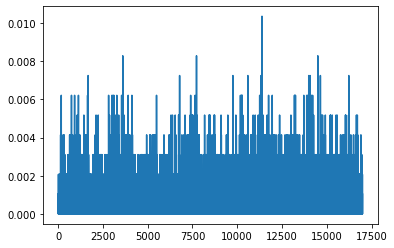

In [122]:
np.shape(start_array)
plot(np.mean(start_array[:,1:],0))
show()

# Now we have the start_array, so let's plot the two conditions with and without Scopo

In [113]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 500 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 32000 # 30 s retrieval plus 2000 after

PSTH,bin_centers = fullPSTH(start_array,bin_size,smoothing_triangle,sr,psth_start)
# bootstraps error bars by sampling from trials in raster with replacement samples number of
# times and then taking the standard deviation across those samples
# boot_samples = bootstrap(start_array, bootnum=samples, samples=None, # bootstrap error bars using resampling
#                bootfunc=lambda x: bootPSTH(x,binsize,smoothing_triangle,sr,psth_start))
# boot_SD = np.std(boot_samples,0)

# get binned start array (trials X bins)
binned_start_array = binBinaryArray(start_array,bin_size,sr_factor)
if pad > 0:
    binned_start_array = binned_start_array[:,pad:-pad] # remove edge bins
print('done making binned start_array with shape:')
binned_start_array.shape

# # get trial X 1 categorical names for subjects and sessions # do this in start_array cell now
# if select_ordinal_position == 0: # if 0 already did this in last cell
#     subject_name_array,session_name_array = getSubSessPredictors(sub_names,sub_sess_names,trial_nums)

# note that output is the net ± distance from mean
SE_plot = getMixedEffectSEs(binned_start_array,subject_name_array,session_name_array)
print('SEs created!')

# should all be same length! (sanity check)
print('Are these three the same length?? They should be!')
binned_start_array.shape
len(subject_name_array)
len(session_name_array)

if scopo_selection == 0:
    PSTH_control = copy(PSTH)
    SE_control = copy(SE_plot)
    start_array_control = copy(start_array)
    subject_name_array_control = copy(subject_name_array)
    print('Saved control PSTH!')
elif scopo_selection == 1:
    PSTH_scopo = copy(PSTH)
    SE_scopo = copy(SE_plot)
    start_array_scopo = copy(start_array)
    subject_name_array_scopo = copy(subject_name_array)    
    print('Saved scopolamine PSTH!')

done making binned start_array with shape:


(966, 64)

SEs created!
Are these three the same length?? They should be!


(966, 64)

966

966

Saved scopolamine PSTH!


/scratch/john/SWR_scopolamine/WHOLE_RETRIEVAL/SWR_FR1_scopolamine_UT255_1_HPC_whole_retrieval_soz_in_hamming.p
966 recalls


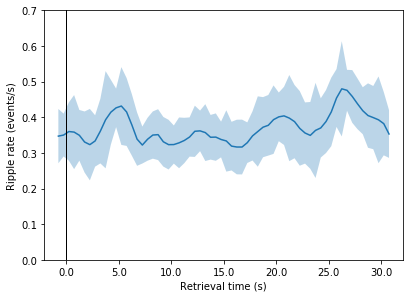

In [39]:
save_plot_data = 0

# # let's measure significance at two key 500 ms bins (and compare to similar bin 500 ms earlier/later)
# stats_bin = 500 # time bin width in ms to test stats on

# first_start = -1600 # going to make sequence of 3 bins and test 1st v. 3rd
# first_end = -100
# second_start = 200 # same idea
# second_end = 1700

# start_array.shape
# binned_first_stats_array = start_array[:,int((first_start-psth_start)/sr_factor):int((first_end-psth_start)/sr_factor)]
# binned_second_stats_array = start_array[:,int((second_start-psth_start)/sr_factor):int((second_end-psth_start)/sr_factor)]
# binned_first_stats_array = binBinaryArray(binned_first_stats_array,stats_bin,sr_factor)
# binned_second_stats_array = binBinaryArray(binned_second_stats_array,stats_bin,sr_factor)
# print('done binning start_arrays'); binned_start_array.shape

# bin_model1 = MEstatsAcrossBins(binned_first_stats_array[:,[0,2]],subject_name_array,session_name_array)
# bin_model2 = MEstatsAcrossBins(binned_second_stats_array[:,[0,2]],subject_name_array,session_name_array)
# # bin_model1.summary()
# # bin_model2.summary()


## plot PSTH and save data for plot (see SWRplots)


subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

# plot smoothed mean +/- CI
if pad > 0:
    plot(xr[pad:-pad],PSTH[pad:-pad])
    fill_between(xr[pad:-pad], PSTH[pad:-pad]-SE_plot[0,:], PSTH[pad:-pad]+SE_plot[0,:], alpha = 0.3)
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
# title('Mean of ripples for '+experiment)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
xticks(np.arange(0,30001,5000),np.arange(0,30.001,5.000))
xlabel('Retrieval time (s)')

# # plot bands of significance
# if bin_model1.pvalues[1] < 0.05:
#     plot([first_end-stats_bin,first_end],[0.2,0.2],color=(1,0.5,0))
# if bin_model2.pvalues[1] < 0.05:
#     plot([second_start,second_start+stats_bin],[0.2,0.2],color=(1,0.5,0))
# num_trials = start_array.shape[0]

print(fn)
# print('Test 1 p-value: '+str(bin_model1.pvalues[1]))
# print('Test 2 p-value: '+str(bin_model2.pvalues[1]))
print(str(len(start_array))+' recalls')

if save_plot_data == 1:
    fn = os.path.join(path_name,
    'SWR_FR1_scopolamine_'+region_name+'_'+location_selected+'_'+str(recall_type_switch)+'_'+soz_label+\
                  '_'+filter_type+'_'+sub_selection+'.p') # -GT_5000.p' # -LT_5000.p' #'-intrusions.p'
    # get strings for path name for save and loading cluster data
    soz_label,recall_selection_name,subfolder = getSWRpathInfo(remove_soz_ictal,recall_type_switch,selected_period,recall_minimum)
        
    path_name = '/home1/john/SWR/figures/'+subfolder
    if os.path.isdir(path_name) == False:
        os.mkdir(path_name)
    if type(location_selected)==list:
        location_selected = 'ca1dg'
    with open(fn,'wb') as f:
        pickle.dump({'bin_centers':bin_centers,'PSTH':PSTH,'SE_plot':SE_plot,'num_trials':num_trials,
                    'bin_model1':bin_model1,'bin_model2':bin_model2,
                    'binned_first_stats_array':binned_first_stats_array,'binned_second_stats_array':binned_second_stats_array,
                    'subject_name_array':subject_name_array,'session_name_array':session_name_array,
                    'electrode_array':electrode_array,'channel_coords_array':channel_coords_array}, f)
a=1;

# plot PSTHs scopo and control together and run stats

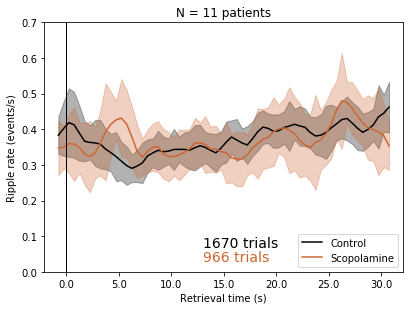

In [66]:
subplots(1,1,figsize=(6,4))
xr = bin_centers #np.arange(psth_start,psth_end,binsize)

color1 = (0,0,0)
color2 = (0.8,0.4,0.2)

# plot smoothed mean +/- CI
if pad > 0:
    plot(xr[pad:-pad],PSTH_control[pad:-pad],color=color1)
    fill_between(xr[pad:-pad], PSTH_control[pad:-pad]-SE_control[0,:], PSTH_control[pad:-pad]+SE_control[0,:], alpha = 0.3, color=color1,label='_nolegend_')
    plot(xr[pad:-pad],PSTH_scopo[pad:-pad],color=color2)
    fill_between(xr[pad:-pad], PSTH_scopo[pad:-pad]-SE_scopo[0,:], PSTH_scopo[pad:-pad]+SE_scopo[0,:], alpha = 0.3, color=color2,label='_nolegend_')    
else:
    plot(xr,PSTH)
    fill_between(xr, PSTH-SE_plot[0,:], PSTH+SE_plot[0,:], alpha = 0.3)

xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,500/1000))
if selected_period == 'surrounding_recall':
    xlabel('Time from recall (s)')
elif selected_period == 'math_retrieval':    
    xlabel('Time from response (s)')
elif selected_period == 'math':
    xlabel('Time from problem onset (s)')
ylabel('Ripple rate (events/s)')
# title('Mean of ripples for '+experiment)
tight_layout()
ax = plt.gca()
if filter_type == 'hamming':
    ylim = 0.7 # keep it here since occasionally CIs get kinda high
else:
    ylim = 0.45
ax.set_ylim(0,ylim)
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]],linewidth=1,linestyle='-',color=(0,0,0));
x_width = [ax.get_xlim()[0],ax.get_xlim()[1]]
xticks(np.arange(0,30001,5000),np.arange(0,30.001,5.000))
title('N = '+str(len(np.unique(sub_names)))+ ' patients')

text(13000,0.07,str(len(start_array_control))+' trials',color=color1,size=14)
text(13000,0.03,str(len(start_array_scopo))+' trials',color=color2,size=14)
ax.legend({'Control','Scopolamine'},loc='lower right')

xlabel('Retrieval time (s)');

# let's get a delta ripple rate for each subject individually

In [116]:
%autoreload
# make a PSTH based on start times of SWRs
bin_size = 500 # in ms
smoothing_triangle = 5 # triangular smoothing window width
samples = 100
pad = int(np.floor(smoothing_triangle/2)) # factor is how many points from middle does triangle go?
psth_start = -2000
psth_end = 32000 # 30 s retrieval plus 2000 after

sub_delta_ripples = []

for sub in np.unique(subject_name_array):
    # control
    sub_start_array_control = start_array_control[subject_name_array_control==sub]
    sub_start_array_control = sub_start_array_control[:,1000:15000+1000]    
    sub_PSTH_control,_ = fullPSTH(sub_start_array_control,bin_size,smoothing_triangle,sr,psth_start)
    
    # scopo
    sub_start_array_scopo = start_array_scopo[subject_name_array_scopo==sub]
    sub_start_array_scopo = sub_start_array_scopo[:,1000:15000+1000]    
    sub_PSTH_scopo,_ = fullPSTH(sub_start_array_scopo,bin_size,smoothing_triangle,sr,psth_start)
    
    sub_delta_ripples.append(np.mean(sub_PSTH_control)-np.mean(sub_PSTH_scopo))
    
    

In [123]:
np.unique(subject_name_array_control)
np.unique(subject_name_array_scopo)

array(['UT159', 'UT162', 'UT165', 'UT167', 'UT178', 'UT185', 'UT191',
       'UT195', 'UT199', 'UT238', 'UT255'], dtype='<U5')

array(['UT159', 'UT165', 'UT167', 'UT191', 'UT195', 'UT199', 'UT238',
       'UT255'], dtype='<U5')

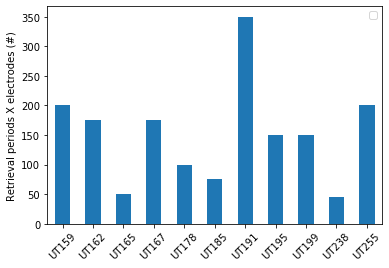

In [107]:
from collections import Counter
letter_counts = Counter(subject_name_array)
df = pd.DataFrame.from_dict(letter_counts, orient='index')
df.plot(kind='bar')
xticks(rotation=45)
ylabel('Retrieval periods X electrodes (#)')
legend('');

# get raster

(972, 2000)


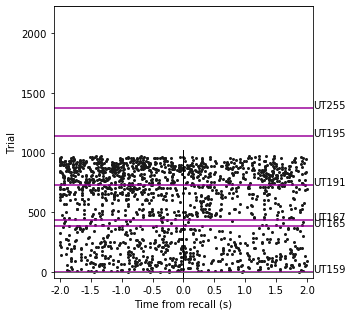

In [65]:
## for the raster and PSTH binarize the data by using the start indices of the ripple

# Remember you gotta set recall_type_switch to 0 for this to fill out the full raster properly

save_raster = 0

elec_dividers_on = 0 # toggles light gray lines between electrodes
session_dividers_on = 0

dot_color = (0.1,0.1,0.1)
between_subject_color = (0.6,0,0.6)
between_session_color = (0,0.6,0.6)

%autoreload
psth_start = -2000
psth_end = 2000

# plot raster
subplots(1,1,figsize=(5,4.5))   #y=100 for data cleaning # (4,6) for Fig. 4b # (4,10) for Fig. 2a

scatter(np.where(start_array)[1]*sr_factor+psth_start,np.where(start_array)[0],s=4,color=dot_color) # SWR time v. trial
xticks(np.arange(psth_start,psth_end+1,500),np.arange(psth_start/1000,psth_end/1000+1,0.5))
xlabel('Time from recall (s)')
ylabel('Trial')
ax = plt.gca()
ax.set_xlim(psth_start-100,psth_end+100)
plot([0,0],[ax.get_ylim()[0],ax.get_ylim()[1]], linewidth=1,linestyle='-',color=(0,0,0))

last_sub = sub_names[0]
last_sess = sub_sess_names[0]
channels_per_session = []
trial_accum = 0
for s in range(0,len(trial_nums)):
    if (sub_names[s] != last_sub) | (s==1) | (s==0):
        if s != 1:
            # plot dark gray line between subjects
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=1.5,linestyle='-',color=between_subject_color)
            last_sub = sub_names[s]
            text(2100,0.5+np.sum(trial_nums[:s]),sub_names[s])
        elif s == 0:
            text(2100,0,sub_names[s])
        else: 
            if session_dividers_on==1:
                # if 1st sub though gotta print that first gray line 
                plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=between_session_color)
                text(2100,0,sub_names[s]) # and print 1st sub name at y=0
    else: # plot lines between electrodes
        if elec_dividers_on == 1:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.5,linestyle='-',color=(.8,.8,.8))
    # plot lines between sessions
    if session_dividers_on==1:
        if sub_sess_names[s] != last_sess:
            plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums[:s]))*np.ones(2),linewidth=0.75,linestyle='-',color=between_session_color)
            last_sess = sub_sess_names[s]
            
    channels_per_session.append(np.unique(channel_nums_array[int(trial_accum):int(trial_accum+trial_nums[s])]))
    trial_accum = trial_accum+trial_nums[s]
    
plot([ax.get_xlim()[0],ax.get_xlim()[1]],-.5*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))        
plot([ax.get_xlim()[0],ax.get_xlim()[1]],(0.5+np.sum(trial_nums))*np.ones(2),linewidth=1,linestyle='-',color=(.4,.4,.4))
ax.autoscale(enable=True, axis='y', tight=True)
plt.tight_layout()
# print('Total FR events: '+str(total_recalls)) # these were in whole retrieval period so not kept in usual ripple alignment
# print('Kept FR events: '+str(kept_recalls))
print(start_array.shape);
if save_raster == 1:
    if elec_dividers_on == 1:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'-'+filter_type+'.pdf',transparent=True)       
    else:
        plt.savefig('../figures/rasters/'+exp+'_'+'raster_'+region_name+'_'+location_selected+
                    '-'+str(recall_type_switch)+'no_elecs-'+filter_type+'.pdf',transparent=True)
a=1;

In [ ]:
test = read_single_matlab_matrix_as_numpy_structured_array(
                '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/events.mat', 'events')
np.shape(test)
np.array(test.dtype.names)
pd.DataFrame.from_records(test)

test2 = read_single_matlab_matrix_as_numpy_structured_array(
                '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/MATH_events.mat', 'events')
np.shape(test2)
np.array(test2.dtype.names)
pd.DataFrame.from_records(test2)

# sub = 'UT162'
# session = 1

# evs = pd.DataFrame.from_records( read_single_matlab_matrix_as_numpy_structured_array(
#        '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][1]+'/session_'+str(1)+'/events.mat', 'events') )   

# # UTSW data annoyingly uses 'item' instead of 'item_name'
# evs = evs.rename(columns={"item": "item_name"})

# # 1) change evs.recalled to False 2) comment out nonrepeat_indicator>0 for good_recalls = (or it removes all the -1s) 
# # 3) set getOutputPositions to [] 4) change save name at bottom to '_intrusions.p'
# evs_free_recall = evs[(evs.type=='REC_WORD') & (evs.intrusion==0)] # recalled word AND correct (from this list...False for instrusions).        
# word_evs = evs[evs['type']=='WORD'] # get words 

# test1 = read_single_matlab_matrix_as_numpy_structured_array(
#                 '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/events.mat','events')
# test1
# type(test1)
# np.shape(test1)
# pd.DataFrame.from_records(test1)

# test = read_single_matlab_matrix_as_numpy_structured_array(
#                 '/data/eeg/'+sub+'/behavioral/'+behav_names[i_sub][i_session]+'/session_'+str(session)+'/MATH_events.mat','MATH_events')
# test
# type(test)
# np.shape(test)